# CSE 6240 Homework 2  
  
__Name: Qi Zheng__  
__GTID: qzheng61__

### Notes:
__Results are summarized at the beginning of each section.__

In [2]:
import numpy as np
import pandas as pd
from scipy import sparse
import sklearn
import matplotlib.pyplot as plt
import collections
from IPython.display import Image
from scipy.stats import pearsonr

## Problem 1. MovieLens 100K

In [3]:
U = 943
I = 1682

df_u = pd.read_csv('u.data', header=None, delimiter="\t", usecols=[0, 1, 2])
df_uab = pd.read_csv('ua.base', header=None, delimiter="\t", usecols=[0, 1, 2])
df_uat = pd.read_csv('ua.test', header=None, delimiter="\t", usecols=[0, 1, 2])

In [4]:
df_u.shape

(100000, 3)

In [5]:
u_complete = df_u.as_matrix()
uab = df_uab.as_matrix()
uat = df_uat.as_matrix()

### 1.1 Data Visualization

### 1.1a  Plot the histogram of the variable: num of movie ratings (bins = 100)

__In this section, the total set of numbers(counts) of movie ratings has been binned into 100 bins, a histogram of the 100 bins has been created.__

In [15]:
def hist_plot(data, bin_num, title, xlabel, ylabel):
    plt.figure(figsize=(12, 6))
    plt.title(title, fontsize=18)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    # plt.hist(data, bins = max(collections.Counter(data).keys(), key=int), color = '#5f67e8')
    plt.hist(data, bins = bin_num)
    plt.show()

In [16]:
print(u_complete.shape)
print(len(collections.Counter(u_complete[:,1])))

(100000, 3)
1682


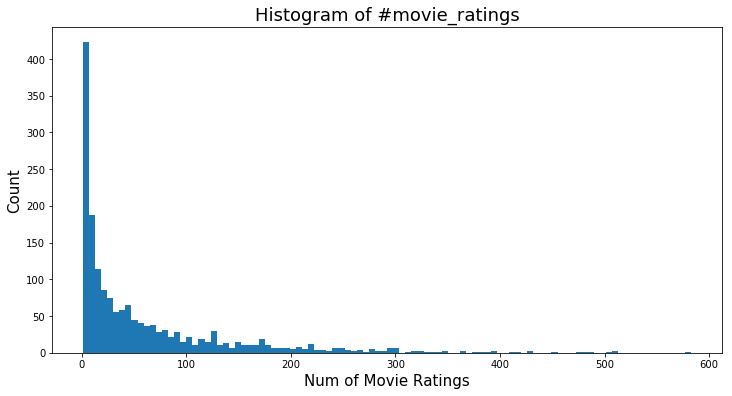

In [18]:
U_arr = np.zeros(U)
M_arr = np.zeros(I)
for item in u_complete:
    U_arr[item[0]-1]+=1
    M_arr[item[1]-1]+=1

bin_a = 100
title_a = "Histogram of #movie_ratings"
xlabel_a = "Num of Movie Ratings"
ylabel_a = "Count"
hist_plot(M_arr, bin_a, title_a, xlabel_a, ylabel_a)


### 1.1b  Plot the histogram of the variable: num of user ratings (bins = 100)

__ In this section, the total set of numbers(counts) of movie ratings has been binned into 100 bins, a histogram of the 100 bins has been created.__

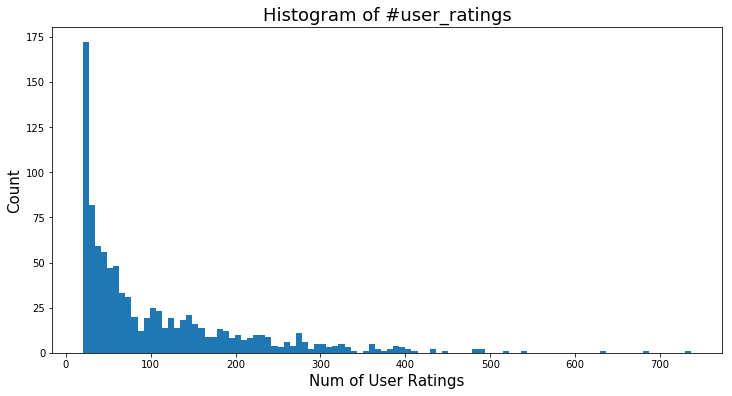

In [19]:
bin_b = 100
title_b = "Histogram of #user_ratings"
xlabel_b = "Num of User Ratings"
ylabel_b = "Count"
hist_plot(U_arr, bin_b, title_b, xlabel_b, ylabel_b)

### 1.2 Baseline Predictor

### 1.2a  Estimate μ, b<sub>u</sub>, b<sub>i</sub>

In this section, bu and bi have been estimated emperically using the decoupling method. For the Netflix data, λ2 = 25, λ3 = 10 have been used.  

#### Results obtained from my model are :
mean rating(µ) = 3.52382687424  
Mean value of bi:  -0.100823893735  
Mean value of bu:  0.00623655377883    
__RMSE for ua_test = 0.966481783888__

These results match those reported on paper.

In [9]:
# Generate matrix A for ua_base and ua_test

uab[:, 0] -= 1
uab[:, 1] -= 1
uat[:, 0] -= 1
uat[:, 1] -= 1

In [1]:
# print(uab)
# print(uat)

In [11]:
# Generate U(user) by I(movie) sparse matrixes
# in csr and csc formats respectively
# coo_matrix((data, (row, col)), shape=(M, N))

# Estimate the bu, bi values emperically using the decoupling method
# For the Netflix data, the mean rating (µ) is 3.6, use λ2 = 25, λ3 = 10.

A_ua = sparse.csr_matrix((uab[:,2],(uab[:, 0], uab[:, 1])),shape=(U, I))
Aa = np.array(A_ua.todense())
T_ua = sparse.csr_matrix((uat[:,2],(uat[:, 0], uat[:, 1])),shape=(U, I))
Ta = np.array(T_ua.todense())

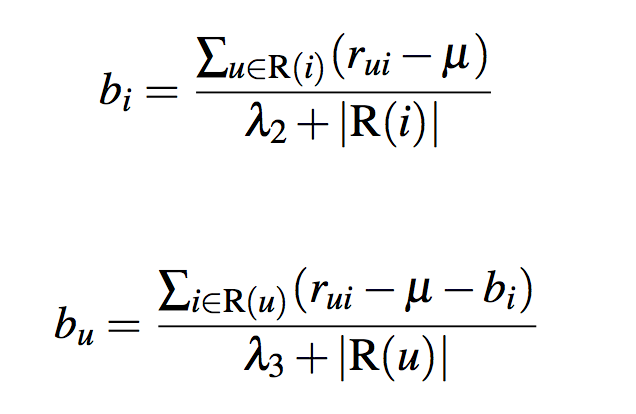

In [12]:
Image(filename='P1.png',width =250)

# Estimate the bu, bi values emperically using the decoupling method
# For the Netflix data, λ2 = 25, λ3 = 10 are typically used.

In [16]:
# Calculate bu, bi

sum_up = uab[:, 2].sum()
(totalcounts, _) = uab.shape
miu = sum_up/totalcounts
print("miu =", miu)

lmd2 = 25
lmd3 = 10

bI = np.zeros(I)
for i in range(I):
    Ri = np.count_nonzero(Aa[:, i])
    sum_Ri = Aa[:, i].sum()
    if Ri != 0:
        bI[i] = (sum_Ri - miu*Ri)/(Ri+lmd2)

# Check the mean value of bi
print('Mean value of bi: ', np.mean(bI))

bU = np.zeros(U)
for u in range(U):
    Ru = np.count_nonzero(Aa[u, :])
    sum_Ru = Aa[u, :].sum()
    if Ru != 0:
        sum_bi = 0
        for i in range(I):
            if Aa[u, i] != 0:
                sum_bi += bI[i]
        bU[u] = (sum_Ru - miu*Ru-sum_bi)/(Ru+lmd3)

# Check the mean value of bi        
print('Mean value of bu: ', np.mean(bU))

miu = 3.52382687424
Mean value of bi:  -0.100823893735
Mean value of bu:  0.00623655377883


In [17]:
Ta_pred = np.zeros(shape=(U, I))
Ta_diff = np.zeros(shape=(U, I))
Ta_sqdf = np.zeros(shape=(U, I))
for u in range(U):
    for i in range(I):
        Ta_pred[u, i] = miu + bU[u] + bI[i]
Ta_pred = np.where(Ta == 0, 0, Ta_pred)
Ta_diff = Ta - Ta_pred
Ta_sqdf = np.square(Ta_diff)
Ct = np.count_nonzero(Ta)
rmse = np.sqrt(Ta_sqdf.sum()/Ct)
# Check the RMSE for the whole traing set ua_test
print('RMSE for ua_test =', rmse)

RMSE for ua_test = 0.966481783888


### 1.2b  Plot the RMSE per user _x_ movie rating

This part has been removed from the assignment.

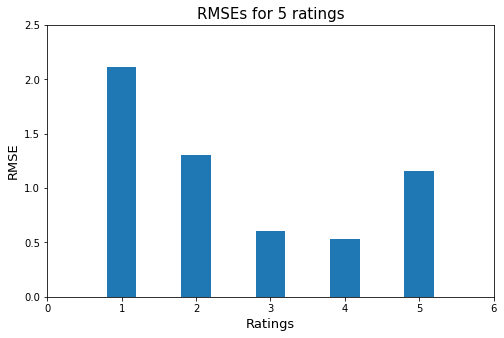

In [565]:
# Create a list of 5 matrices corresponding to
# the predicted ratings for actual ratings ranging from 1 to 5

RMSE_a = []

for i in range(1, 6):
    diff = np.zeros(shape=(U, I))
    diff = np.where(Ta == i, Ta_pred-Ta, diff)
    St = np.count_nonzero(diff)
    diff = diff * diff
    rmse = np.sqrt(diff.sum()/St)
    RMSE_a.append(rmse)

RMSE_a = np.asarray(RMSE_a)

x = [1, 2, 3, 4, 5]
plt.figure(figsize=(8, 5))
plt.title('RMSEs for 5 ratings', fontsize = 15)
plt.xlabel('Ratings', fontsize = 13)
plt.ylabel('RMSE', fontsize = 13)
plt.xlim(0, 6)
plt.ylim(0, 2.5)
plt.bar(x, RMSE_a, width=.4)

plt.show()

### 1.2c  Plot the RMSE per user

In this section, users have been binned into 5 bins based on their average ratings, which range from 1.489 to 4.929.

Bins = [1.489, 2.177, 2.865, 3.553, 4.241, 4.929]    
RMSEs for 5 user bins are:  [ 1.10886597  1.15083431  1.00076338  0.92640898  0.88786692]

In [179]:
mean_rating = []
for u in range(U):
    count = np.count_nonzero(Aa[u, :])
    mean_rating.append(Aa[u, :].sum()/count)
mean_rating = np.array(mean_rating)

In [534]:
(_, bin5) = np.histogram(mean_rating, bins=5)
# print(bin5)
indices = np.digitize(mean_rating, bin5)
groups = [[], [], [], [], []]

for userid in range(U):
    if mean_rating[userid]<bin5[1]:
        groups[0].append(userid)
    elif mean_rating[userid]<bin5[2]:
        groups[1].append(userid)
    elif mean_rating[userid]<bin5[3]:
        groups[2].append(userid)
    elif mean_rating[userid]<bin5[4]:
        groups[3].append(userid)
    else:
        groups[4].append(userid)

In [574]:
def RMSE_user_plt(groups, Ta_sqdf, bin5, title_plt):
    group_sqdf = []

    for usergroup in groups:
        bin_sum = 0
        St = 0
        for u in usergroup:
            bin_sum += Ta_sqdf[u, :].sum()
            St += 10
        group_sqdf.append(np.sqrt(bin_sum/St))

    group_sqdf = np.array(group_sqdf)

    x = np.zeros(5)
    for i in range(5):
        x[i] = (bin5[i]+bin5[i+1])/2

    plt.figure(figsize=(8, 5))
    plt.title(title_plt, fontsize = 15)
    plt.xlabel('5 user bins based on mean rating', fontsize = 13)
    plt.ylabel('RMSE', fontsize = 13)
    plt.xticks(bin5)
    # plt.ylim(0, 1.4)
    plt.xlim(0, 6)
    plt.bar(x, group_sqdf, width= 0.67)

    plt.show()

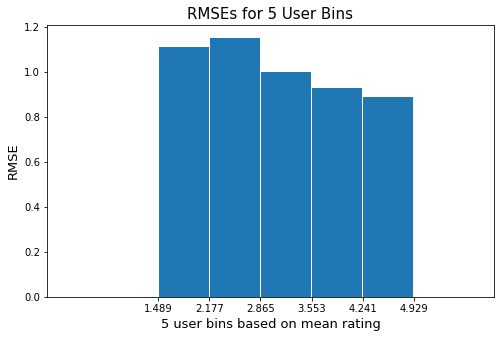

In [576]:
RMSE_user_plt(groups, Ta_sqdf, bin5, 'RMSEs for 5 User Bins')

In [542]:
# Print out the valuse
print("RMSEs for 5 user bins are: ", group_sqdf)

RMSEs for 5 user bins are:  [ 1.10886597  1.15083431  1.00076338  0.92640898  0.88786692]


### 1.3  KNN (K-Nearest Neighbor) 

### 1.3a  RMSE for k=1, 2, 3, 5, 10

In this section, a recommender system has been built based on Paper[2] section 4.2. Item -item similarity matrix has been computed, KNN has been computed from weighted sums based on the similarity matrix. The corresponding RMSEs for k = 1, 2, 3, 5, 10 are:  

__1.3764014  
1.19151056  
1.12159919  
1.07672316  
1.32908066__

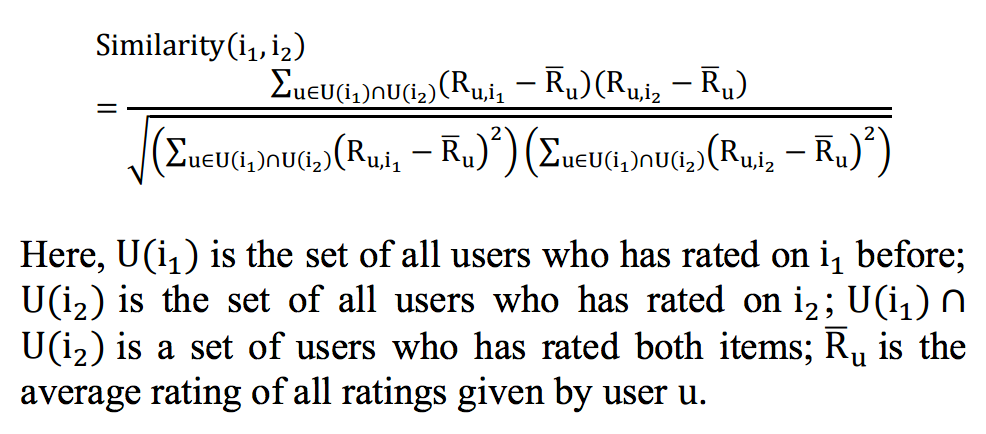

In [22]:
Image(filename='P2.png',width=450)

# Use the following equation to calculate Sim(i, j)

In [195]:
# Sim is an upper triangular matrix
# with zeros on the diagonal
Sim = np.zeros(shape=(I, I))

# Atten: directly applying the equation
# will generate nan where the denominators are zeros

for i in range(I):
    for j in range(i+1, I):
        Ai = np.copy(Aa[:, i])
        Aj = np.copy(Aa[:, j])
        m = np.ones(U)
        m[Ai==0]=0
        m[Aj==0]=0
        
        Ai = Ai - mean_rating
        Aj = Aj - mean_rating
        
        Ai[m==0] = 0
        Aj[m==0] = 0
        
        sum1 = np.sqrt((Ai*Ai).sum())
        sum2 = np.sqrt((Aj*Aj).sum())
        Sim[i,j] = np.dot(Ai, Aj)/(sum1*sum2)

/Users/zq/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in double_scalars


In [206]:
nan_num = np.count_nonzero(np.isnan(Sim))*2
print('Size of the similarity matrix:', Sim.size)
print('Number of NaN\'s in the similarity matrix:', nan_num)

Size of the similarity matrix: 2829124
Number of NaN's in the similarity matrix: 894228


In [280]:
# NaNs will be generated where
# the denominators are zeros.
# Replace these values with 0

sim = np.copy(Sim)

for p,q in np.argwhere(np.isnan(sim)):
    sim[p, q] = 0

for i in range(I):
    sim[i,i] = 0
    for j in range(i):
        sim[i, j] = sim[j, i]

In [472]:
user, item = np.nonzero(Ta)
sim_ind = []


for line in sim:
    sim_ind.append(line.argsort()[::-1])
    
sim_ind = np.array(sim_ind)

In [488]:
def pagen(U, I, item, user, sim_ind, sim, Aa, k):
    Pa = np.zeros(shape=(U, I))
    for it in range(item.size):
        i = item[it]
        u = user[it]
        s_sum = 0
        sR_sum = 0
        ct = 0
        for j in sim_ind[i]:
            if Aa[u, j] > 0:
                s_sum += abs(sim[i, j])
                sR_sum += Aa[u, j]*sim[i, j]
                ct += 1
                if ct >= k:
                    break
        Pa[user[it], item[it]] = sR_sum/s_sum
        
    for nx,ny in np.argwhere(np.isnan(Pa)):
        nz = Aa[nx]
        avg = nz[nz!=0].mean()
        Pa[nx, ny] = avg
        
    return Pa

In [489]:
def cal_rmse(Ta_p, Ta_t, Ct):
    Ta_df = Ta_p - Ta_t
    Ta_df = np.square(Ta_df)
    rmse = np.sqrt(Ta_df.sum()/Ct)
    return rmse

In [577]:
Pa_list = []
knnlist = [1, 2, 3, 5, 10]
for k in knnlist:
    Pa_list.append(pagen(U, I, item, user, sim_ind, sim, Aa, k))

In [494]:
knn_rmse = []
for Pa in Pa_list:
    knn_rmse.append(cal_rmse(Pa, Ta, Ct))
    
knn_rmse = np.array(knn_rmse)

In [495]:
print(knn_rmse)

[ 1.3764014   1.19151056  1.12159919  1.07672316  1.32908066]


### 1.3c  Plot the RMSE per user

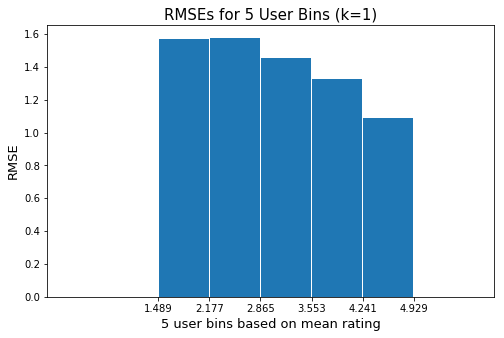

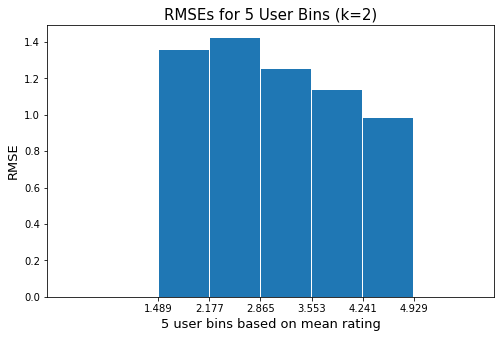

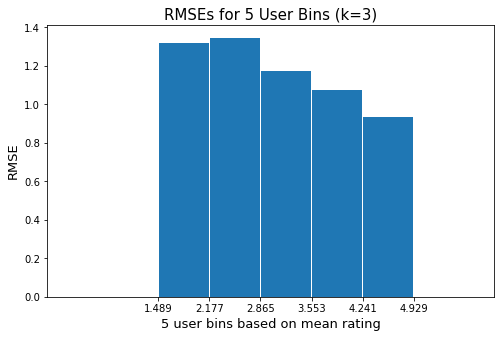

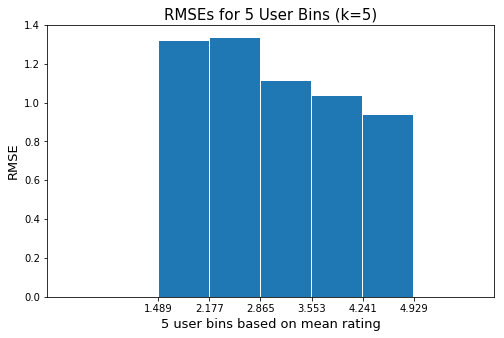

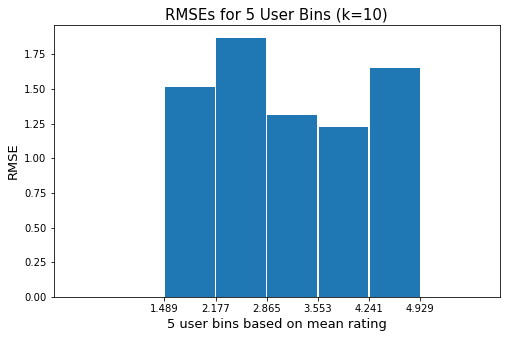

In [568]:
for i in range(5):
    ki = knnlist[i]
    Pa_knn = Pa_list[i]
    Pa_sqdf = Pa_knn - Ta
    Pa_sqdf = Pa_sqdf*Pa_sqdf
    RMSE_user_plt(groups, Pa_sqdf, bin5, 'RMSEs for 5 User Bins '+'(k='+str(ki)+')')